In [1]:
# # ML Trader
import numpy as np
import pandas as pd

from scipy.stats import linregress
import math

import collections

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import datetime as dt

import winsound

import warnings
warnings.filterwarnings('ignore')

In [2]:
def before_sema(data):   
    data['sema_list'].append(data['tick'])    
    return(data)

def after_sema(data):     
    data['sema_list'].popleft()
    data['sema_list'].append(data['tick'])
    data['sema'] = list(pd.DataFrame(list(data['sema_list'])).ewm(span=data['sema_len']).mean()[0])[-1]
    return(data)

def before_lema(data):   
    data['lema_list'].append(data['tick'])    
    return(data)

def after_lema(data):     
    data['lema_list'].popleft()
    data['lema_list'].append(data['tick'])
    data['lema'] = list(pd.DataFrame(list(data['lema_list'])).ewm(span=data['lema_len']).mean()[0])[-1]
    return(data)

In [3]:
def print_report(data):
    display.clear_output(wait = True)
    print('--------------------------')
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-----------')
    print(data['pl_list'])
    print('--------------------------')
    return()

In [4]:
def read_data(data):
    source_file_path = f'..\\data\\yearly_tick_data\\{data["year"]}.csv'

    if data['input_rows'] is None:
        data["df"] = pd.read_csv(source_file_path)
    else:
        data["df"] = pd.read_csv(source_file_path, nrows=data['input_rows'])
        
    data["df"] = data["df"][data["df"]['DateTime'].str.contains('|'.join(data['date_list']))]
#     data["df"] = data["df"][data["df"]['DateTime'].str.contains(data['date_val'])]
    
    data["df"]['tick'] = np.float()
    data["df"]['sema'] = np.float()
    data["df"]['lema'] = np.float()
    
    return(data["df"])

In [5]:
def get_dir(data):
    
    if data['sema'] > data['lema']:
        data['position'] = 1

    elif data['sema'] < data['lema']:
        data['position'] = -1
    
    return(data)

In [6]:
def after_dir(data):   
    
    data['dir_list'].popleft()
    data['dir_list'].append(data['position'])   
    
    if sum(data['dir_list']) != 0:
        data['dir_change'] = False

    elif sum(data['dir_list']) == 0:
        data['dir_change'] = True

    return(data)

In [7]:
def make_order(data):
    if not data['open_order']:
        if data['dir_change']:
            if data['position'] > 0:
                data['order_ask_price'] = data['ask']
                data['open_order'] = True
                data['open_order_type'] = 'long'
                
                data['buy_markers_x'].append(data['i_list'][-1])
                data['buy_markers_y'].append(data['ask'])
                
            elif data['position'] < 0:
                data['order_bid_price'] = data['bid']
                data['open_order'] = True
                data['open_order_type'] = 'short'
                
                data['buy_markers_x'].append(data['i_list'][-1])
                data['buy_markers_y'].append(data['bid'])
                
    return(data)

In [8]:
def close_order(data):
    if data['open_order']:
        if data['dir_change']:
            if data['position'] < 0:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['bid'])               
                
            elif data['position'] > 0:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['ask'])                  
                
    return(data)

In [9]:
def tick_close(data):
    if data['open_order']:
        if data['open_order_type'] == 'short':
            if data['tick'] - data['lema'] >= 0:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['ask'])  
                
        if data['open_order_type'] == 'long':
            if data['lema'] - data['tick'] >= 0:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
                data['sell_markers_x'].append(data['i_list'][-1])
                data['sell_markers_y'].append(data['bid'])                  
                
    return(data)

In [10]:
def get_date_list(data):
    
    data['start_date'] = dt.datetime(year=data['start_date']['year'],
                      month=data['start_date']['month'],
                      day=data['start_date']['date'])

    data['end_date'] = dt.datetime(year=data['end_date']['year'],
                      month=data['end_date']['month'],
                      day=data['end_date']['date'])

    
    date_list = list(pd.date_range(data['start_date'],data['end_date'],freq='d').values)
    data['date_list'] = [str(x).split('T')[0].replace('-','') for x in date_list]
    return(data)

In [11]:
def get_run_duration(data):
    run_time = len(data["date_list"]) * 6
    hours = run_time//60
    mins = run_time%60
    print(f'Approx run time : {hours}-hours : {mins}-mins')

In [12]:
def split_date_col(data):
    data['total_df']['year_val'] = [x.year for x in data['total_df']['date']]
    data['total_df']['month_val'] = [x.month for x in data['total_df']['date']]
    data['total_df']['date_val'] = [x.day for x in data['total_df']['date']]
    data['total_df']['hour_val'] = [x.hour for x in data['total_df']['date']]
    data['total_df']['minute_val'] = [x.minute for x in data['total_df']['date']]

In [13]:
def get_date_lines(data):
    data['line_list'] = []
    
    for dt_val  in data['date_list']:    
        data['line_list'].append(data["df"][data["df"]['DateTime'].str.contains(dt_val)].index[0])
    
    return(data)

In [14]:
def plot_graph(data):
    fig, ax = plt.subplots(figsize=(50,10))

    x_axis = np.arange(0,len(data["df"]['tick']))

    ax.plot(x_axis, data["df"]['tick'], label='tick', color='green')
    ax.plot(x_axis, data["df"]['sema'], label='sema', color='blue')
    ax.plot(x_axis, data["df"]['lema'], label='lema', color='red')
    
    data = get_date_lines(data)
    
    for x_val in data['line_list']:
        plt.axvline(x=x_val, color='black')
    
    ax.scatter(data['buy_markers_x'], data['buy_markers_y'], s=300, c='b')
    ax.scatter(data['sell_markers_x'], data['sell_markers_y'], s=300, c='r')

    legend = ax.legend(loc='upper left', fontsize='xx-large')
    plt.xlabel('tick num')
    plt.ylabel('prices')
    plt.title('trade chart')
    plt.show()

In [15]:
def print_report(data):
    pl_list = list(data['pl_list'])
    net_pl = round(np.sum(pl_list),5)

    positive_pls = [i for i in pl_list if i > 0]
    negative_pls = [i for i in pl_list if i < 0]

    num_positive = len(positive_pls)
    num_negative = len(negative_pls)

    sum_positive = round(np.sum(positive_pls),5)
    sum_negative = round(np.sum(negative_pls),5)
    sum_total    = round(sum_positive + abs(sum_negative),5) 

    avg_positive = round(np.mean(positive_pls),5)
    avg_negative = round(np.mean(negative_pls),5)

    
    print('==============================')
    print(f'date_val          : {data["date_list"]}')    
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-------------')
    print(f'net_pl            : {net_pl}/{sum_total}')  
    print('-------------')
    print(f'+ve               : num= {num_positive}    sum= +{sum_positive}    avg= +{avg_positive}')
    print(f'-ve               : num= {num_negative}    sum= {sum_negative}    avg= {avg_negative}')
    print('==============================')

In [16]:
def get_slope(data):
    #global data
    ma_len = len(data['y_axis'])
    
    x_axis = []
    for i in range(ma_len):
        x_axis.append(1 + ((i+1) * 0.00001))
    
    slope_tick, intercept, _, _, _ = linregress(x_axis, data['y_axis'])
    data['angle'] = math.degrees(math.atan(slope_tick))
    
    return(data)

def run_engine(data):
    for i in tqdm(range(0, len(data["df"]))):
        
        data['ask'] = data["df"]['Ask'][i]
        data['bid'] = data["df"]['Bid'][i]
        data['tick'] = (data['ask'] + data['bid'])/2    
        data["df"]['tick'][i] = data['tick']
        
        #data['dt_val'] = data["df"]['DateTime'][i]        
        data['dt_val'] = dt.datetime.strptime(data["df"]['DateTime'][i].split(".")[0],"%Y%m%d %H:%M:%S")

        # sema before after loops --------------------------------
        if len(data['sema_list']) < data['sema_len']:
            data =  before_sema(data)

        if len(data['sema_list']) == data['sema_len']:
            data = after_sema(data)     
        # ----------------------------------------------------------


        # lema before after loops --------------------------------
        if len(data['lema_list']) < data['lema_len']:
            data = before_lema(data)        
            continue

        if len(data['lema_list']) == data['lema_len']:
            data = after_lema(data)        
        # ----------------------------------------------------------


        data["df"]['sema'][i] = data['sema']
        data["df"]['lema'][i] = data['lema']
        data['df']['i'] = i

        data = get_dir(data)

        # lema before after loops --------------------------------
        if len(data['dir_list']) < 2:
            data['dir_list'].append(data['position'])   
            continue
        elif len(data['dir_list']) == 2:
            data = after_dir(data)
        # ----------------------------------------------------------
        
        print(data["df"]['sema'][-data['angle_len']:])
        data['y_axis'] = data["df"]['sema'][-data['angle_len']:]
        data = get_slope(data['y_axis'])
        data['angle_list'].append(data['angle'])
        data = tick_close(data)
        data = close_order(data)
        data = make_order(data)    

    data['len_to_subtract'] = len(data["df"][data["df"]['lema'] == 0])
    data['buy_markers_x'] = list(np.array(data['buy_markers_x']) - data['len_to_subtract'])
    data['sell_markers_x'] = list(np.array(data['sell_markers_x']) - data['len_to_subtract'])
    
    data["df"] = data["df"][data["df"]['sema'] != 0]
    data["df"] = data["df"][data["df"]['lema'] != 0]
    data["df"] = data["df"].reset_index(drop = True)
    
    return(data)

In [17]:
def run_engine(data):
    for i in tqdm(range(0, len(data["df"]))):
        
        data['ask'] = data["df"]['Ask'][i]
        data['bid'] = data["df"]['Bid'][i]
        data['tick'] = (data['ask'] + data['bid'])/2    
        data["tick_list"].append(data['tick'])
        
        #data['dt_val'] = data["df"]['DateTime'][i]        
        data['dt_val'] = dt.datetime.strptime(data["df"]['DateTime'][i].split(".")[0],"%Y%m%d %H:%M:%S")

        # sema before after loops --------------------------------
        if len(data['sema_list']) < data['sema_len']:
            data =  before_sema(data)

        if len(data['sema_list']) == data['sema_len']:
            data = after_sema(data)     
        # ----------------------------------------------------------


        # lema before after loops --------------------------------
        if len(data['lema_list']) < data['lema_len']:
            data = before_lema(data)        
            continue

        if len(data['lema_list']) == data['lema_len']:
            data = after_lema(data)        
        # ----------------------------------------------------------

        data["df_sema_list"].append(data['sema'])
        data["df_lema_list"].append(data['lema'])        
        data['i_list'].append(i)

        data = get_dir(data)

        # Get Dirs --------------------------------
        if len(data['dir_list']) < 2:
            data['dir_list'].append(data['position'])   
            continue
        elif len(data['dir_list']) == 2:
            data = after_dir(data)
        # ----------------------------------------------------------
        
#         print(data["df"]['sema'][-data['angle_len']:])
#         data['y_axis'] = data["df"]['sema'][-data['angle_len']:]
#         data = get_slope(data['y_axis'])
#         data['angle_list'].append(data['angle'])

        data = tick_close(data)
        data = close_order(data)
        data = make_order(data)    


    
    
    print(f'data["df"]: {len(data["df"])}')
    data["df"] = data['df'][-len(data["df_lema_list"]):]   
    data["df"] = data["df"].reset_index(drop = True)
    print(f'data["df"]: {len(data["df"])}')
    
    data["df"]['lema'] = data["df_lema_list"]        
    
    data["df_sema_list"] = list(data["df_sema_list"])[-len(data["df_lema_list"]):]
    data["df"]['sema'] = data["df_sema_list"]
    
    data['df']["tick"] = list(data["tick_list"])[-len(data["df_lema_list"]):]
    
    #data['len_to_subtract'] = len(data["df"][data["df_lema_list"] == 0])
    data['len_to_subtract'] = data['lema_len']
    data['buy_markers_x'] = list(np.array(data['buy_markers_x']) - data['len_to_subtract'])
    data['sell_markers_x'] = list(np.array(data['sell_markers_x']) - data['len_to_subtract'])    

#     data["df"] = data["df"][data["df"]['sema'] != 0]
#     data["df"] = data["df"][data["df"]['lema'] != 0]
    data["df"] = data["df"].reset_index(drop = True)
    
    return(data)

In [18]:
data = {}
data["year"] = 2021
data['total_df'] = pd.DataFrame()
data['sema_list'] = collections.deque()
data['lema_list'] = collections.deque()
data['dir_list'] = collections.deque()
data['pl_list'] =  collections.deque()
data['dt_list'] =  collections.deque()
data['angle_list'] = []
data['tick_list'] = []
data['df_sema_list'] = []
data['df_lema_list'] = []

data['i_list'] = []


data['buy_markers_x'] = []
data['buy_markers_y'] = []

data['sell_markers_x'] = []
data['sell_markers_y'] = []

data['open_order_type'] = None

In [19]:
data['input_rows'] = None

data['start_date'] = {'year':2021, 'month':2, 'date':8}
data['end_date']   = {'year':2021, 'month':2, 'date':8}

data['sema_len'] = 1500
data['lema_len'] = 3000

data['angle_len'] = 500

  1%|▎                                     | 628/63647 [00:00<00:10, 6234.54it/s]

Record num : 63647


100%|█████████████████████████████████████| 63647/63647 [03:18<00:00, 320.30it/s]


data["df"]: 63647
data["df"]: 60647


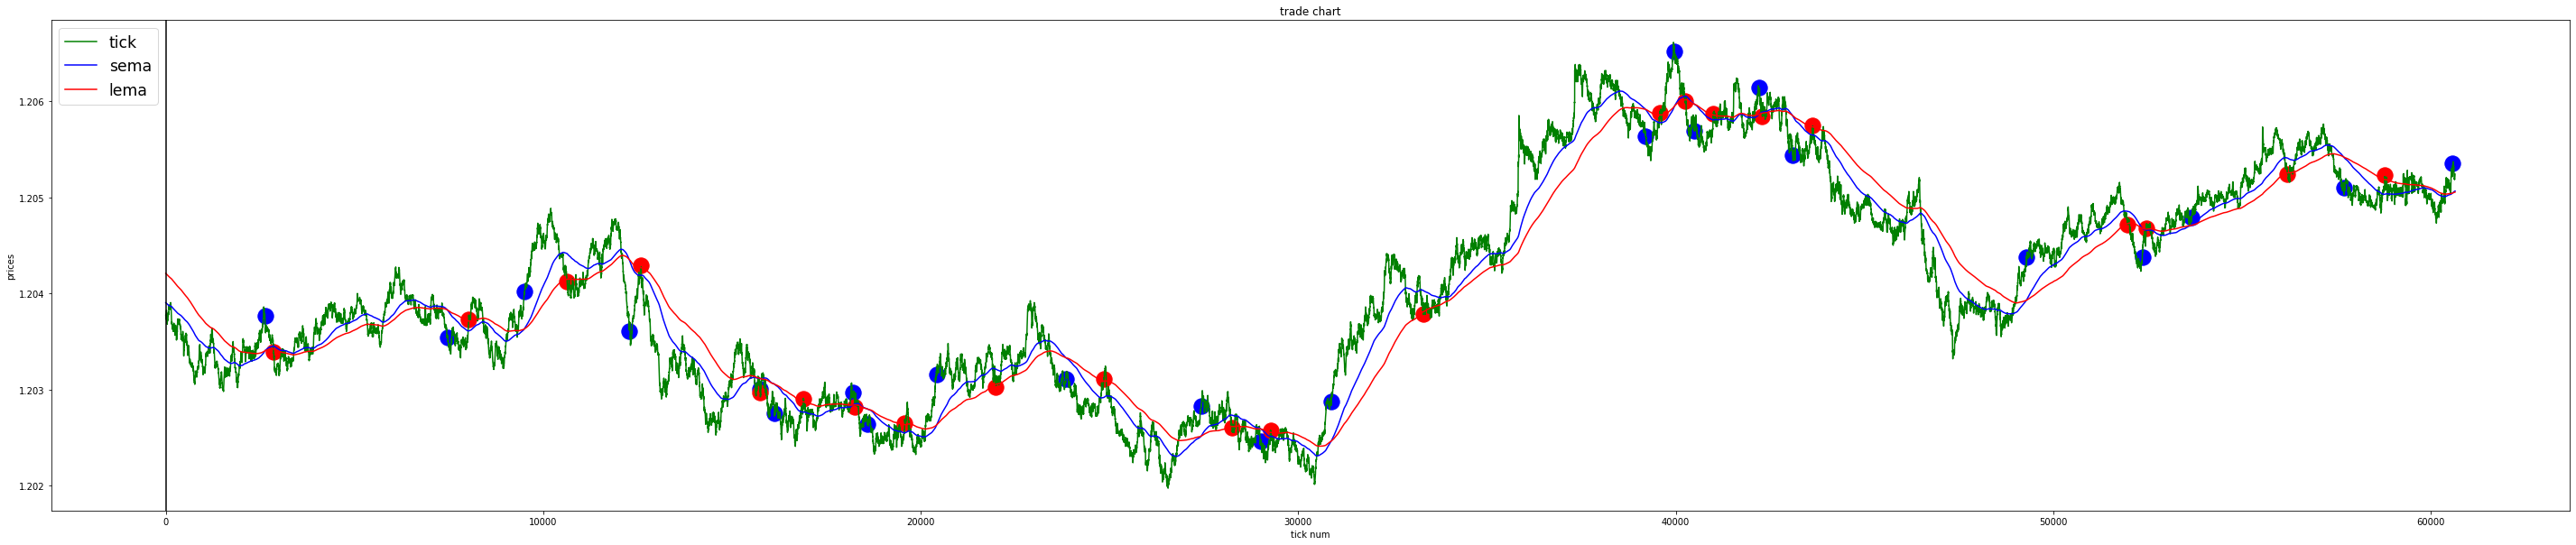

date_val          : ['20210208']
Total PL : -0.0023
-------------
net_pl            : -0.0023/0.0057
-------------
+ve               : num= 4    sum= +0.0017    avg= +0.00042
-ve               : num= 15    sum= -0.004    avg= -0.00027
Wall time: 3min 23s


In [20]:
%%time
data = get_date_list(data)
read_data(data)
# data["df"] = data["df"][0:10000]
print(f'Record num : {len(data["df"])}')    
data["df"] = data["df"].reset_index(drop = True)
data['df']['i'] = np.int()
data['open_order'] = False    
data = run_engine(data)

plot_graph(data)
print_report(data)
data['total_df'] = pd.DataFrame({'date':data['dt_list'], 'pls': data['pl_list']})
split_date_col(data)
data['total_df'] = data['total_df'][['date', 'year_val', 'month_val', 'date_val', 'hour_val','minute_val', 'pls']]
data["total_df"] = data["total_df"].reset_index(drop = True)    
data['file_name'] = f'data\{data["start_date"].year}-{data["start_date"].month}-({data["start_date"].day}-{data["end_date"].day}).csv'

data['total_df'].to_csv(data['file_name'], index = False) 

In [21]:
print(data['total_df'].groupby(['date_val'])['pls'].sum())

date_val
8   -0.0023
Name: pls, dtype: float64


In [22]:
data['total_df']['pls'].value_counts()

-0.0002    6
-0.0001    3
-0.0003    3
-0.0000    3
-0.0004    1
-0.0005    1
 0.0003    1
 0.0001    1
 0.0009    1
 0.0004    1
-0.0007    1
Name: pls, dtype: int64

In [23]:
data['df']

,DateTime,Bid,Ask,Volume,tick,sema,lema,i
0,20210208 00:46:58.791,1.20375,1.20379,1,1.203770,1.203904,1.204209,0
1,20210208 00:46:59.182,1.20375,1.20378,1,1.203765,1.203903,1.204208,0
2,20210208 00:46:59.284,1.20372,1.20376,4,1.203740,1.203903,1.204208,0
3,20210208 00:46:59.385,1.20372,1.20375,3,1.203735,1.203902,1.204207,0
4,20210208 00:46:59.486,1.20371,1.20375,5,1.203730,1.203902,1.204207,0
...,...,...,...,...,...,...,...,...
60642,20210208 23:59:08.812,1.20521,1.20523,1,1.205220,1.205063,1.205053,0
60643,20210208 23:59:08.964,1.20521,1.20524,1,1.205225,1.205063,1.205053,0
60644,20210208 23:59:09.277,1.20521,1.20525,1,1.205230,1.205063,1.205053,0
60645,20210208 23:59:49.498,1.20521,1.20526,1,1.205235,1.205064,1.205053,0


In [24]:
data['total_df']['pls']

0    -0.0004
1    -0.0002
2     0.0001
3    -0.0007
4    -0.0000
5    -0.0002
6    -0.0002
7    -0.0000
8    -0.0001
9     0.0000
10   -0.0002
11   -0.0001
12    0.0009
13   -0.0002
14   -0.0005
15   -0.0002
16   -0.0003
17   -0.0003
18    0.0003
19   -0.0003
20    0.0004
21   -0.0001
Name: pls, dtype: float64

In [25]:
winsound.PlaySound('C:\\Windows\\Media\\chimes.wav', winsound.SND_ASYNC)